엑셀 파일을 성공적으로 불러왔습니다.
데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              1291 non-null   object        
 1   bundate           1291 non-null   datetime64[ns]
 2   TIME              1291 non-null   int64         
 3   mact4             1291 non-null   float64       
 4   mstdact4          1291 non-null   float64       
 5   mrum4             1291 non-null   float64       
 6   mstdrum4          1291 non-null   float64       
 7   mdate             1291 non-null   datetime64[ns]
 8   mact              1291 non-null   float64       
 9   mrum              1291 non-null   float64       
 10  stdact            1291 non-null   float64       
 11  stdrum            1291 non-null   float64       
 12  birth             1291 non-null   datetime64[ns]
 13  last_in           1291 non-null   datetime64[n

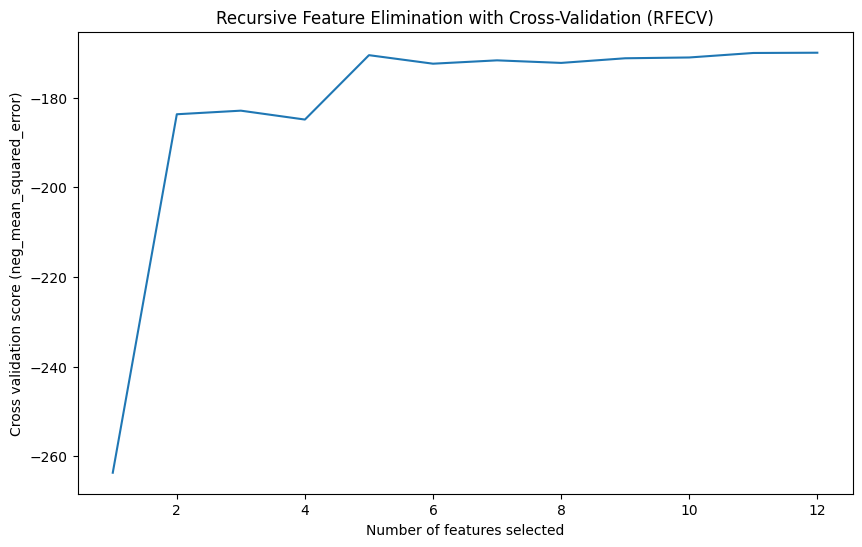


RFECV 분석 및 모델 평가 완료.

데이터를 다음 경로에 저장했습니다:
validation_selected_features2.xlsx


In [1]:
# 필요한 패키지 설치 (로컬에서는 보통 한 번만 설치)
# pip install pandas openpyxl scikit-learn matplotlib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor

# --- 엑셀 파일 경로 설정 (로컬 PC 기준) ---
file_path = 'C:/Users/kibae/Desktop/분만알고리즘/트레이닝데이터/validation_fold_1.xlsx'  # 파일이 같은 폴더에 있으면 이렇게만 적어도 됨

# 엑셀 파일 불러오기
try:
    df = pd.read_excel(file_path)
    print("엑셀 파일을 성공적으로 불러왔습니다.")
    print("데이터프레임 정보:")
    df.info()
    print("\n데이터프레임 상위 5행:")
    print(df.head())
except FileNotFoundError:
    print(f"오류: 파일을 찾을 수 없습니다. 경로를 확인하세요: {file_path}")
    exit()
except Exception as e:
    print(f"파일 불러오기 중 오류 발생: {e}")
    exit()

target_variable_name = input("타겟 변수 명을 입력하세요 (예: c): ")

# 데이터 프레임에 있는 컬럼인지 교차검증
if target_variable_name in df.columns:
    target_variable = df[target_variable_name]
    print(f"'{target_variable_name}'가 타겟 변수로 설정되었습니다.")
    print(target_variable)
else:
    print(f"'{target_variable_name}'는 데이터프레임에 없는 컬럼명입니다. 다음 컬럼 중에서 선택해주세요: {df.columns.tolist()}")

# --- 데이터 전처리 및 특성/타겟 분리 ---

# 숫자형 컬럼만 선택
df_numeric = df.select_dtypes(include=[np.number])

# 타겟이 숫자형인지 확인
if target_variable_name not in df_numeric.columns:
    raise ValueError(f"타겟 변수 '{target_variable_name}'는 숫자형이 아닙니다. RFECV에 사용할 수 없습니다.")

# 결측치 처리 (평균 대체)
df_numeric = df_numeric.fillna(df_numeric.mean())

# X, y 설정
y = df_numeric[target_variable_name]
X = df_numeric.drop(columns=[target_variable_name])

# 데이터 분할 (학습/테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n데이터 분할 결과: 학습 세트 {X_train.shape}, 테스트 세트 {X_test.shape}")

# Estimator는 랜덤포레스트로 (너무느려져서 학습횟수를 좀 줄였습니다.)
estimator = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

# RFECV 설정
# cv: 교차 검증 폴드 수
# step: 각 반복에서 제거할 특성 수 또는 비율
# scoring: 평가 지표
scoring_metric = 'neg_mean_squared_error' 

print(f"\nRFECV를 {estimator.__class__.__name__} Estimator와 {scoring_metric} 스코어링을 사용하여 실행합니다.")

rfecv = RFECV(estimator=estimator, step=2, cv=5, scoring=scoring_metric)

# RFECV 학습 및 특성 선택
rfecv.fit(X_train, y_train)

# 선택된 특성 확인
print("\nRFECV 결과:")
print(f"최적의 특성 개수: {rfecv.n_features_}")
print("선택된 특성 마스크:", rfecv.support_) # True는 선택된 특성
print("특성 랭킹:", rfecv.ranking_) # 1은 선택된 특성, 나머지는 제거된 순위

# 선택된 특성 이름 가져오기
selected_features = X_train.columns[rfecv.support_]
print("\n선택된 특성 이름:")
print(selected_features)

# --- 선택된 특성으로 모델 재학습 및 평가 ---
# 선택된 특성만 사용하여 학습 데이터를 만듭니다.
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 선택된 특성으로 새로운 모델을 학습합니다.
final_model = SVR(kernel="linear") # RFECV에 사용한 것과 동일한 Estimator 사용
final_model.fit(X_train_selected, y_train)

# 테스트 세트 예측
y_pred = final_model.predict(X_test_selected)

# 모델 성능 평가 (회귀 문제 예시: MSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"\n선택된 특성으로 학습된 모델 성능 (회귀):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# --- RFECV 시각화 ---
# 최적 특성 개수 찾기 과정을 시각화할 수 있습니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title('Recursive Feature Elimination with Cross-Validation (RFECV)')
plt.xlabel("Number of features selected")
plt.ylabel(f"Cross validation score ({scoring_metric})")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()


print("\nRFECV 분석 및 모델 평가 완료.")

# --- 엑셀 의 1열,2열과 결과로 나온 특성 열을 합침
df_subset = df.iloc[:, [0, 1]]
df_selected = df_numeric[selected_features]
df_combined = pd.concat([df_subset, df_selected], axis=1)


# 합친 결과를 엑셀 파일로 저장
output_path = 'validation_selected_features2.xlsx'  # 원하는 경로로 수정 예시-> output_path = 'C:\Users\Users\Documents\validation_selected_features.xlsx'
df_combined.to_excel(output_path, index=False)

print(f"\n데이터를 다음 경로에 저장했습니다:\n{output_path}")
